In [1]:
from spkit.simulate_student import SimulateStudent
import numpy as np
from spkit import bkt, pfa, tpfa
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%autoreload 1

In [46]:
%aimport spkit.tpfa

In [47]:
%aimport spkit.pfa
%aimport spkit.simulate_student

In [16]:
# # p(L0)
# pi = [0.26, 0.74]
# # p(T)
# A = [[1, 0], [0.17, 0.83]]
# A = [[0.9, 0.1], [0.17, 0.83]]
# # p(S) and p(G)
# B = [[0.7, 0.3], [0.13, 0.87]]
p_L0 = 0.26
p_T = 0.17
p_S = 0.3
p_G = 0.13
timestamp_prior = [[0.2, 0.4, 0.4], [0.4, 0.4, 0.2]]

data = []
data_time = []
n_questions = 10
students = SimulateStudent(p_L0, p_T, p_S, p_G, timestamp_prior)
for i in range(50):
    last_time = datetime(2019,12,17)
    observations = students.simulate(n_questions)
    for question_id, outcome in enumerate(observations):
        data.append([outcome, i, question_id])
#         ts = students.simulate_timestamp(states[question_id], tpfa.TIME_STEPS  + [timedelta(days=10)], last_time)
#         last_time = ts
#         data_time.append([int(not outcome), i, question_id, ts])
q_matrix = np.array([[1,1,1]]*n_questions)
students = range(50)

In [17]:
%%time
# Instantiate model
model_bkt = bkt.BKT()
model_pfa = pfa.PFA()
#model_tpfa = tpfa.TPFA()

model_bkt.fit(data, q_matrix)
model_pfa.fit(data, q_matrix)
#model_tpfa.fit(data_time, q_matrix)

CPU times: user 568 ms, sys: 31.8 ms, total: 599 ms
Wall time: 609 ms


In [18]:
def get_results(model, data):
    print("Results for model %s" % model)
    data_arr = np.asarray(data)
    rmse = 0
    n = 0
    score_df = []
    learning_state = {}
    outcome_all = []
    predicted_proba = []
    for student in students:
        student_idx = np.where(data_arr[:,1] == student)
        outcome = data_arr[student_idx, 0].astype('int64')
        outcome_all += outcome.tolist()[0]
        question_id = data_arr[student_idx, 2].astype('int64')
        try:
            timestamp = data_arr[student_idx, 3]
            data_student = np.vstack((outcome, question_id, timestamp)).T.tolist()
        except IndexError:
            data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
        
        predicted = model.predict_proba(data_student, q_matrix)
        predicted_proba += predicted[:,1].tolist()
        s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
        fpr, tpr, _ = roc_curve(model.outcomes, predicted[:,1], pos_label=1)
        auc_score = auc(fpr, tpr)
        score_df.append({"student": student,
                         "AIC": s_aic,
                         "BIC": s_bic,
                         "RMSE": s_rmse,
                         "Acc": s_acc,
                         "n questions": model.n_questions,
                         "LL": s_ll,
                         "correct_outcome": np.where(outcome == 1)[1].shape[0],
                         "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                         "AUC": auc_score})
        learning_state[student] = model.get_learning_state()
        
    return pd.DataFrame.from_dict(score_df), outcome_all, predicted_proba

def print_scores(score, outcome, predicted):
    
    # RMSE
    rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
    rmse_avg = score['RMSE'].mean()
    rmse_std = score['RMSE'].std()
    print("RMSE de treino: %.2f" % rmse_train)
    print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))
    
    # Accuracy
    acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
    acc_avg = score['Acc'].mean()
    acc_std = score['Acc'].std()
    print("Acc de treino: %.2f" % acc_train)
    print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))
    
    # AUC
    fpr, tpr, thresholds = roc_curve(outcome, predicted, pos_label=1)
    auc_score = auc(fpr, tpr)
    auc_avg = score['AUC'].mean()
    auc_std = score['AUC'].std()
    # Sensitivity = tpr = TP/(TP+FN)
    # Specificity = 1-fpr = TN/(TN+FP)
    # Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
    J_stats = tpr - fpr
    J_opt_thresholds = thresholds[np.argmax(J_stats)]
    print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
    print("AUC de treino: %.2f" % auc_score)
    print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))
    estimated_outcome = np.where(np.asarray(predicted) > J_opt_thresholds, 1, 0)
    adjusted_acc = (estimated_outcome == np.asarray(outcome)).sum()/score['n questions'].sum()
    print("Adjusted Acc: %.2f" % adjusted_acc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
score_bkt, outcome_bkt, predicted_bkt = get_results(model_bkt, data)
score_pfa, outcome_pfa, predicted_pfa = get_results(model_pfa, data)
#score_tpfa, outcome_tpfa, predicted_tpfa = get_results(model_tpfa, data_time)

Results for model <spkit.bkt.BKT object at 0x7f7a11b391d0>


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


Results for model <spkit.pfa.PFA object at 0x7f7a11bb8f98>


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


RMSE de treino: 0.46
RMSE médio: 0.46 +- 0.08
Acc de treino: 0.68
Acc médio: 0.68 +- 0.18
Youden's optimum threshold: 0.36
AUC de treino: 0.68
AUC médio: 0.53 +- 0.27
Adjusted Acc: 0.68


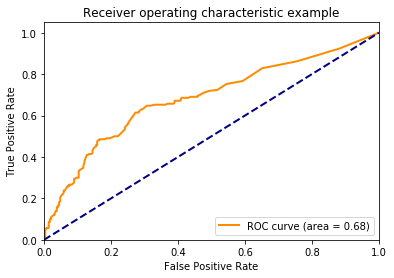

In [20]:
print_scores(score_bkt, outcome_bkt, predicted_bkt)

RMSE de treino: 0.46
RMSE médio: 0.46 +- 0.07
Acc de treino: 0.69
Acc médio: 0.69 +- 0.17
Youden's optimum threshold: 0.47
AUC de treino: 0.69
AUC médio: 0.34 +- 0.26
Adjusted Acc: 0.70


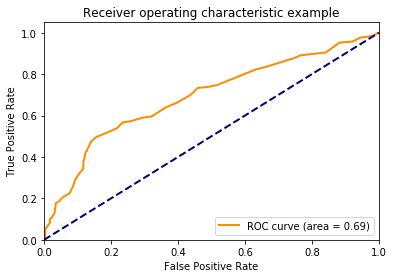

In [21]:
print_scores(score_pfa, outcome_pfa, predicted_pfa)

RMSE de treino: 0.47
RMSE médio: 0.47 +- 0.06
Acc de treino: 0.66
Acc médio: 0.66 +- 0.16
Youden's optimum threshold: 0.46
AUC de treino: 0.68
AUC médio: 0.42 +- 0.24
Adjusted Acc: 0.67


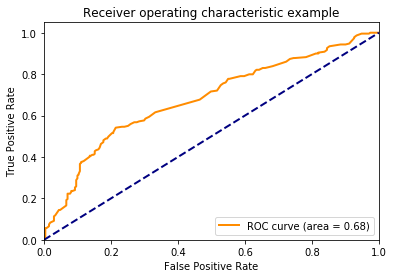

In [54]:
print_scores(score_tpfa, outcome_tpfa, predicted_tpfa)

In [128]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.522